In [2]:
import torch
from torch.nn import functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

In [22]:
inputs = torch.rand((2, 2, 5, 5))

In [124]:
from torch import Tensor
from math import floor, ceil
from numbers import Number



def custom_bilinear_upsample(
        input: Tensor,
        new_size: tuple[int, int] | None = None,
        scale_factor: float | tuple[float, float] | None = None
) : 
    if scale_factor is not None and type(scale_factor) is not tuple:
        scale_factor = (scale_factor, scale_factor)

    if scale_factor is not None:
        print(scale_factor)
        new_size = (round(input.shape[-2] * scale_factor[0]), round(input.shape[-1] * scale_factor[1]))

    if new_size is not None:
        scale_factor = (new_size[0] / input.shape[-2], new_size[1] / input.shape[-1])

    print(new_size)

    batch, channels, input_h, input_w = input.shape

    resized = torch.zeros((batch, channels, new_size[0], new_size[1]))

    for h in range(new_size[0]):
        for w in range(new_size[1]):
            x = h / scale_factor[0]
            y = w / scale_factor[1]

            x_floor = floor(x)
            x_ceil = min(input.shape[-2]-1, ceil(x))
            y_floor = floor(y)
            y_ceil = min(input.shape[-1]-1, ceil(y))




            
            if x_ceil == x_floor and y_ceil==y_floor:
                i = input[:, :, int(x), int(y)]
            elif (x_ceil == x_floor):
                i1 = input[:, :, int(x), int(y_floor)]
                i2 = input[:, :, int(x), int(y_ceil)]
                i = i1 * (y_ceil - y) + i2 * (y - y_floor)
            elif y_ceil == y_floor:
                i1 = input[:, :, int(x_floor), int(y)]
                i2 = input[:, :, int(x_ceil), int(y)]
                i = (i1 * (x_ceil - x)) + (i2 * (x - x_floor))
            else: 
                v1 = input[:, :, x_floor, y_floor]
                v2 = input[:, :, x_ceil, y_floor]
                v3 = input[:, :, x_floor, y_ceil]
                v4 = input[:, :, x_ceil, y_ceil]

                i1 = v1 * (x_ceil-x) + v2 * (x-x_floor)
                i2 = v3 * (x_ceil-x) + v4 * (x - x_floor)
                i = i1 * (y_ceil - y) + i2 * (y - y_floor)

            resized[:, :, h, w] = i

    return resized

In [72]:
tensor_img = read_image('./img/gameboy.jpg').unsqueeze(0) / 255

torch.Size([1, 3, 30, 39])


(-0.5, 38.5, 29.5, -0.5)

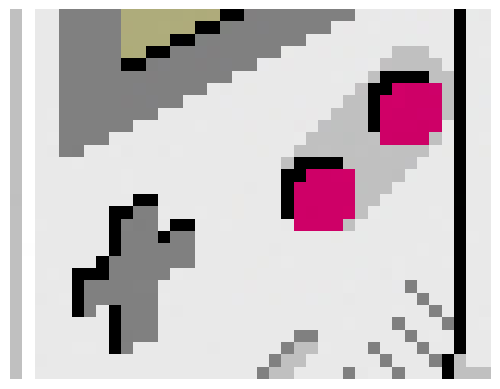

In [136]:
plt.imshow(tensor_img.squeeze(0).permute(1, 2, 0))
print(tensor_img.shape)
plt.axis('off')

In [134]:
upsampled = custom_bilinear_upsample(tensor_img, scale_factor=(4,5))

(4, 5)
(120, 195)


(-0.5, 194.5, 119.5, -0.5)

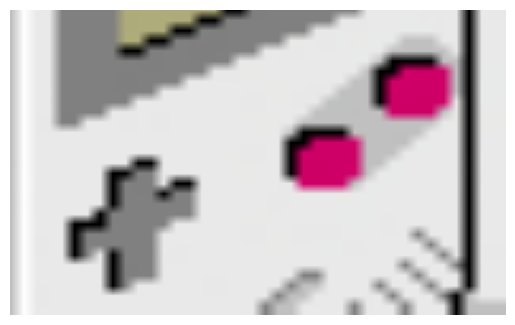

In [135]:
plt.imshow(upsampled.squeeze(0).permute(1, 2, 0))
plt.axis('off')

In [79]:
import ipytest
ipytest.autoconfig()

In [137]:
%%ipytest

def test_1():
    inputs = torch.rand(1, 1, 2, 2)
    scale_factor = 2

    reference = F.upsample(inputs, scale_factor=scale_factor, mode='bilinear', align_corners=True)
    subject = custom_bilinear_upsample(inputs, scale_factor=scale_factor)

    print(reference)
    print(subject)

    assert torch.any(torch.eq(reference, subject))

def test_2():
    inputs = tensor_img
    scale_factor = 1.5

    reference = F.upsample(inputs, scale_factor=scale_factor, mode='bilinear', align_corners=True)
    subject = custom_bilinear_upsample(inputs, scale_factor=scale_factor)

    print(reference)
    print(subject)

    assert torch.any(torch.eq(reference, subject))

def test_3():
    inputs = torch.rand(2, 3, 6, 6)
    new_size = [27, 27]

    reference = F.upsample(inputs, size=new_size, mode='bilinear', align_corners=True)
    subject = custom_bilinear_upsample(inputs, new_size=new_size)

    print(reference)
    print(subject)

    assert torch.any(torch.eq(reference, subject))

...                                                                                          [100%]
========================================= warnings summary =========================================
t_ac6afd9a422a4e508ed18a698ca5a4e1.py::test_1
t_ac6afd9a422a4e508ed18a698ca5a4e1.py::test_2
t_ac6afd9a422a4e508ed18a698ca5a4e1.py::test_3
  /home/klepoz/Study/CV/.venv/lib/python3.11/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
    warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
3 passed, 3 warnings in 0.51s
